# Basic Auto Encoder
notebool source: [rasbt/deeplearning-models](https://github.com/cwyark/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-basic.ipynb)

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
device = torch.device("mps") if torch.mps.is_available() else "cpu"
print("device: ", device)

device:  mps


In [4]:
# hyper parameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
batch_size = 256

In [5]:
# Archiecture
num_features = 784
num_hidden_1 = 32

In [6]:
# MNIST datasets
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

# MNIST dataloader
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100.0%
100.0%
100.0%
100.0%


In [7]:
for images, labels in train_dataloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break;


Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [8]:
# Auto Enoder Model
class AutoEncoder(torch.nn.Module):
    def __init__(self, num_features):
        super(AutoEncoder, self).__init__()

        # encoder layer
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)

        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        # decoder layer
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)

        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

    def forward(self, x):
        # encode
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)

        # decode
        logits = self.linear_2(encoded)
        decoded = torch.sigmoid(logits)

        return decoded

In [9]:
torch.manual_seed(random_seed)
model = AutoEncoder(num_features=num_features)
model = model.to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
# Train
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_dataloader):

        features = features.view(-1, 28*28).to(device)

        # forward and back prop
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        cost.backward()

        # update optimizer
        optimizer.step()

        if not batch_idx % 50:
            print(f"Epoch: {epoch+1}/{num_epochs} | Batch {batch_idx}/{len(train_dataloader)} | Cost: {cost:.4f}")

    print(f"Time elapsed: {(time.time() - start_time)/60}")

print(f"Total traing time: {(time.time() - start_time) / 60}")

Epoch: 1/5 | Batch 0/235 | Cost: 0.7098
Epoch: 1/5 | Batch 50/235 | Cost: 0.2097
Epoch: 1/5 | Batch 100/235 | Cost: 0.1603
Epoch: 1/5 | Batch 150/235 | Cost: 0.1373
Epoch: 1/5 | Batch 200/235 | Cost: 0.1269
Time elapsed: 0.060590795675913495
Epoch: 2/5 | Batch 0/235 | Cost: 0.1193
Epoch: 2/5 | Batch 50/235 | Cost: 0.1110
Epoch: 2/5 | Batch 100/235 | Cost: 0.1079
Epoch: 2/5 | Batch 150/235 | Cost: 0.1037
Epoch: 2/5 | Batch 200/235 | Cost: 0.1032
Time elapsed: 0.09466836452484131
Epoch: 3/5 | Batch 0/235 | Cost: 0.1022
Epoch: 3/5 | Batch 50/235 | Cost: 0.1025
Epoch: 3/5 | Batch 100/235 | Cost: 0.0992
Epoch: 3/5 | Batch 150/235 | Cost: 0.0955
Epoch: 3/5 | Batch 200/235 | Cost: 0.0965
Time elapsed: 0.12988961537679036
Epoch: 4/5 | Batch 0/235 | Cost: 0.0986
Epoch: 4/5 | Batch 50/235 | Cost: 0.0964
Epoch: 4/5 | Batch 100/235 | Cost: 0.0988
Epoch: 4/5 | Batch 150/235 | Cost: 0.0973
Epoch: 4/5 | Batch 200/235 | Cost: 0.0931
Time elapsed: 0.16647746562957763
Epoch: 5/5 | Batch 0/235 | Cost: 0.

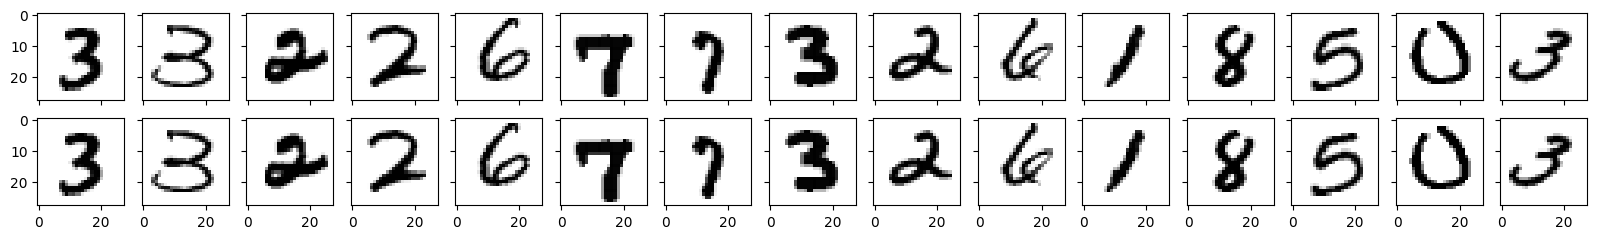

In [24]:
# evaluation
import matplotlib.pyplot as plt

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = features[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device("cpu"))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')